## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

In [2]:
#Print two images next to each other:
def print2images(img1,img2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax1.set_title('Image1', fontsize=50)
    ax2.imshow(img2)
    ax2.set_title('Image2', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [3]:
# Function that uses the calibration images and returns the object points and image points to calebrate an image
def calibrate():
    #reading in the path to callibration images
    images = glob.glob("camera_cal/calibration*.jpg")

    nx = 9 #number of inside corners in x
    ny = 6 #number of inside corners in y

    objectpoints=[] #3D Points in real world
    imagespoints=[] #2D Points in image plane

    #TODO: What am I doing here?
    objp=np.zeros((ny*nx,3), np.float32)
    objp[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1,2)


    for fname in images:
        img = cv2.imread(fname) #reading in
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to gray
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret: #If cornes found add images points & object points
            imagespoints.append(corners)
            objectpoints.append(objp)
    return [objectpoints,imagespoints]

# Function that takes an image performs the camera calibration, image distortion correction and 
# performs the camera calibration, image distortion correction and returns the undistorted image
def image_undistort(img, objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

### Apply a distortion correction to raw images.

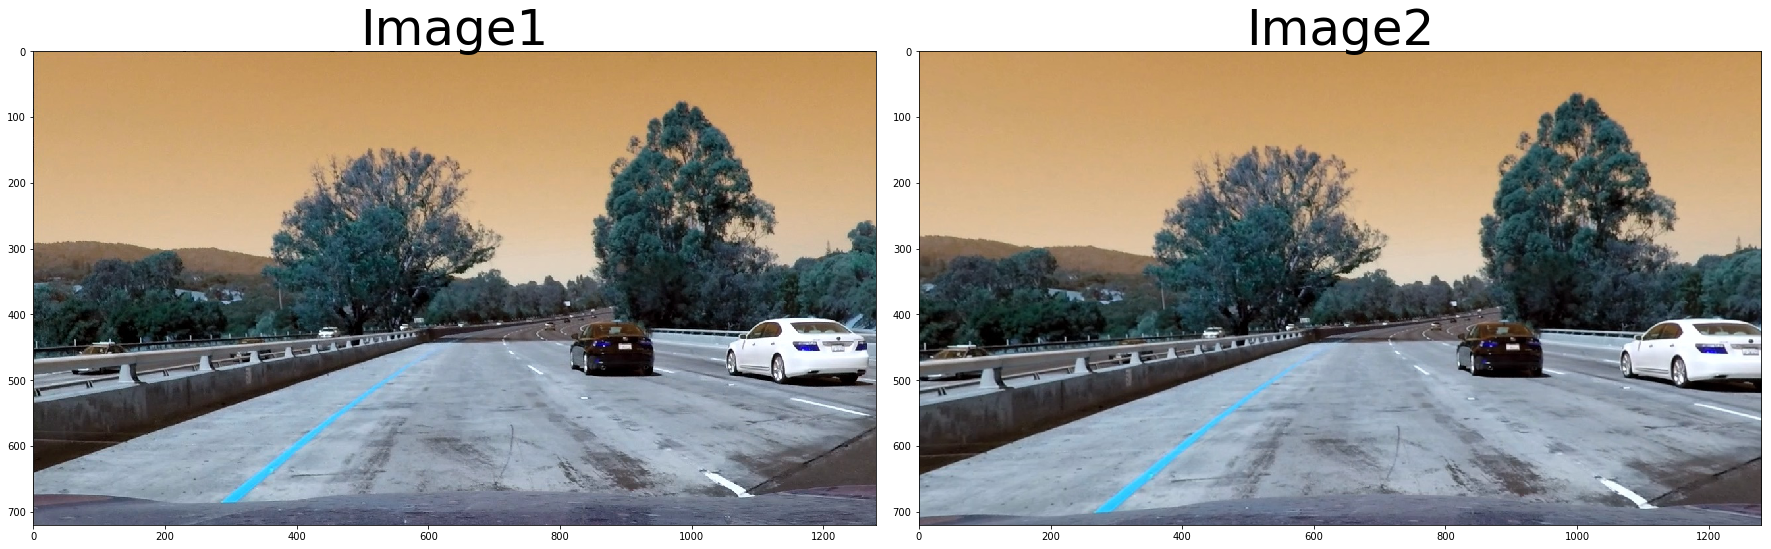

In [4]:
img = cv2.imread('test_images/test1.jpg')
objectpoints, imagespoints=calibrate()
undist=image_undistort(img, objectpoints, imagespoints)
print2images(img,undist)

### Use color transforms, gradients, etc., to create a thresholded binary image.

In [5]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
     # Take the derivative in x or y given orient = 'x' or 'y'
    if orient=='x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    sbinary = np.zeros_like(scaled_sobel)
    #TODO: Is this special numpy Syntax?
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    return sbinary #mask

def mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100)):
    'Calculate gradient magnitude'
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    #TODO: Why do I not take the absolute derivative here?
    gradmag = np.sqrt(sobelx**2 + sobely**2)

    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    return binary_output #mask

def dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction
    # An orientation of 0 implies a vertical line -> 0, np.pi/2
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output #mask

In [10]:
def pipeline(image, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(image)
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    #TODO: How could the l channel be usefull? Should I use it for the x gradient?
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # TODO: I can optimize my thershold with the functions above
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    combined_binary = np.zeros_like(s_channel)
    gradx=abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
    grady=abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(20, 100))
    mag_binary=mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))
    dir_binary=dir_threshold(img, sobel_kernel=3, thresh=(0.7, 1.3))
    combined_binary[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1)] = 1
    
    # Stack each channel to get a image where I can see the influences of the diffrent masks in green and blue
    # TODO: Print this to optimize the therholds
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    return combined_binary
    

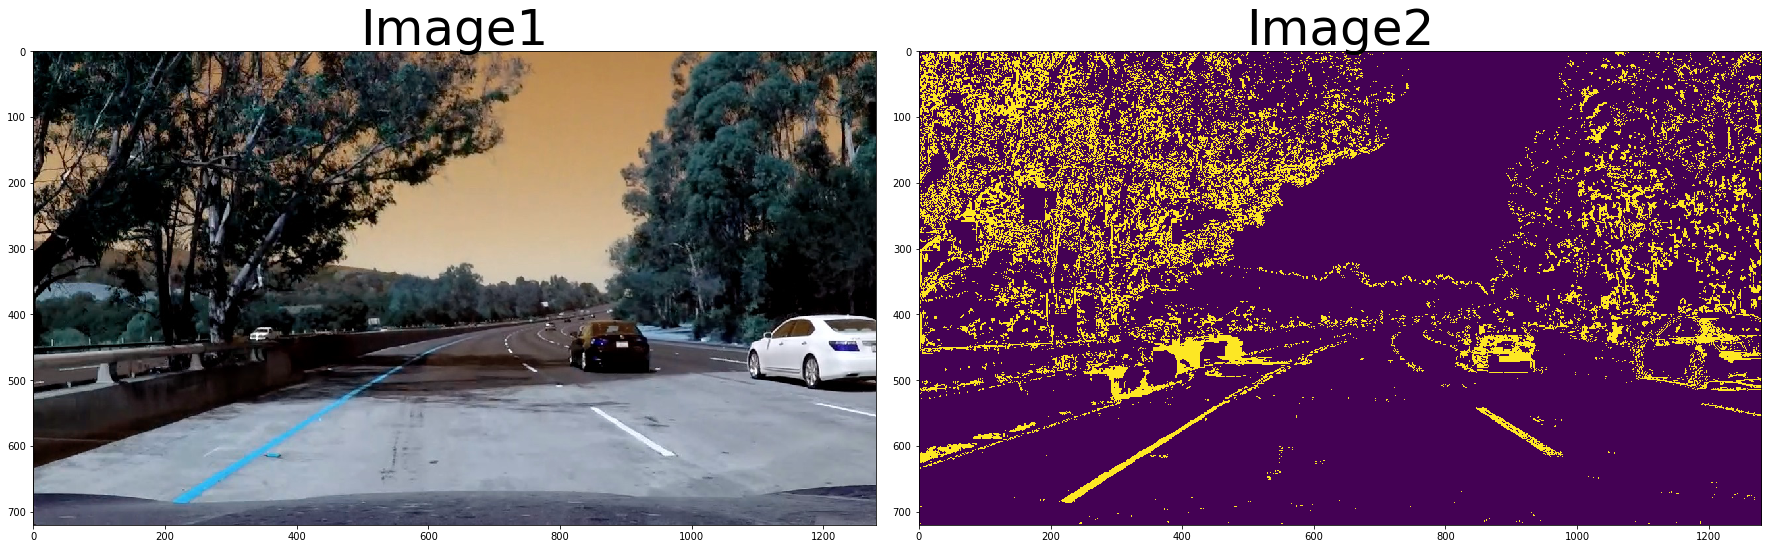

In [11]:
image=cv2.imread('test_images/test5.jpg')
edges=pipeline(image, s_thresh=(170, 255), sx_thresh=(20, 100))
print2images(image,edges)

### Apply a perspective transform to rectify binary image ("birds-eye view")